In [1]:
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-white', 'seaborn-ticks'])
from mpl_toolkits.mplot3d import Axes3D

from random import random

import numpy as np

import mlgrad.model as model
import mlgrad.func as func
import mlgrad.regular as regular
import mlgrad.loss as loss
import mlgrad.weights as weights
import mlgrad.averager as averager

from mlgrad import averager_it, averager_fg, fg, erm_fg, sg, erm_sg, irgd, erm_irgd, erisk

In [2]:
loss_func_sq = loss.ErrorLoss(func.Square())
loss_func_abs = loss.ErrorLoss(func.Absolute())
loss_func_sqrt = loss.ErrorLoss(func.Sqrt(1.0))
loss_func_logsq = loss.ErrorLoss(func.LogSquare(1.0))

In [3]:
def sigma_neuron_layer2(n_input, n_output):
    layer = model.GeneralModelLayer(n_input)
    outfunc = func.Arctang()
    for i in range(n_output):
        mod = model.SigmaNeuronModel(outfunc, n_input)
        layer.models.append(mod)
    layer.n_input = n_input
    layer.n_output = n_output
    layer.n_param = sum(mod.n_param for mod in layer.models)
    return layer

In [4]:
def create_nn(n_input, n_hidden):
    layer1 = sigma_neuron_layer2(n_input, n_hidden[0])
    layer2 = sigma_neuron_layer2(n_hidden[0], n_hidden[1])
    layer3 = sigma_neuron_layer2(n_hidden[1], n_hidden[2])

    body = model.FFNetworkModel()
    body.add(layer1)
    body.add(layer2)
    body.add(layer3)

    head = model.LinearModel(n_hidden[2])
    ffnn = model.FFNetworkFuncModel(head, body)
    ffnn.allocate()
    return ffnn

In [5]:
def generate_nn(n_input, n_hidden):
    nn_orig = create_nn(n_input, n_hidden)
    for layer in nn_orig.body.layers:
        layer_param = layer.param[:]
        n = len(layer_param)
        random_param = 4*np.random.random(n)-2
        for i in range(n):
            layer_param[i] = random_param[i]
    head_param = nn_orig.head.param
    head_param[0] = 0.
    for i in range(n_hidden[-1]):
        head_param[i+1] = (-1.)**i #/((i+1.))
    return nn_orig


In [6]:
result = {}

n_input = 2
n_hidden = (7, 7, 3)

In [7]:
nn_orig = generate_nn(n_input, n_hidden)
print(nn_orig.param.base)

[ 0.          1.         -1.          1.          0.10629773 -1.01188005
 -1.39346743  0.90223303  1.43047068  1.96094101 -1.37405076 -1.82477807
 -0.03999879  0.45918926 -1.86381992  0.04869774 -0.16327198 -1.94942141
  1.0724299   1.69183732  1.15012935  0.21914326  0.53158791  1.74670476
  0.76801979 -0.1721847   1.96185621  1.38887406 -1.2048396   1.30467881
 -1.25611868 -0.83246465 -0.13703786 -0.37340895  1.69849449 -0.42031825
  0.7978957  -0.73030942 -1.6927515  -1.85809454 -0.5984296   0.87945349
 -1.26990926 -0.19445378 -1.88187444  1.09270315 -0.26399712  0.18140239
 -0.46187173 -0.47573405 -1.41932512  0.67029743 -1.23335487 -0.37373966
 -1.28955408  1.93012362 -1.03384978 -0.52017368 -1.66346031 -1.8259695
 -1.87843393  1.26084734  0.08944958  0.79479776 -0.27460726  1.60637354
 -1.62928886  0.17284996  0.34251388  1.96358618 -0.5062455   1.9487984
 -1.19253132  1.8985598  -0.18015629 -0.31535624  1.64657146 -1.64581682
  0.9490247  -0.17182556 -1.51379038 -0.81509796  1.9

In [8]:
Q = 45
q = Q / 100.

N = 50
M = int(q*N*N)

4.127897279986011


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

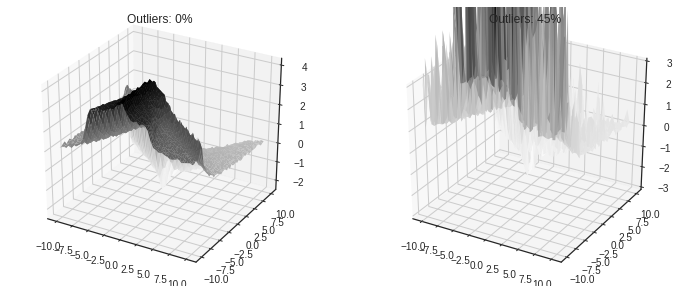

In [9]:
xrange = np.linspace(-10., 10., N)
yrange = np.linspace(-10., 10., N)
xxrange, yyrange= np.meshgrid(xrange, yrange, indexing='xy')
#iirange, jjrange= np.meshgrid(xrange, yrange, indexing='ij')
X = np.c_[xxrange.ravel(), yyrange.ravel()]
Y = np.array(nn_orig.evaluate_all(X))
Y_s = Y + 0.1*(2*np.random.random(N*N)-1)
print(np.max(Y))
YY = Y_s.reshape(xxrange.shape)
I = np.random.permutation(np.arange(0,N*N))[:M]
Y_o = Y_s.copy()
for i in I:
    yi = Y_o[i]
    s = random()
    Y_o[i] += s * abs(yi) * 3
YY_o = Y_o.reshape(xxrange.shape)

# plt.figure(figsize=(12,4))
# plt.subplot(1,2,1)
# cb1 = plt.imshow(YY, extent=(-7.,7.,-7.,7.), origin='bottom', interpolation='none')
# plt.colorbar(cb1)
# plt.subplot(1,2,2)
# cb2 = plt.imshow(YY_o, extent=(-7.,7.,-7.,7.), origin='bottom', interpolation='none')
# plt.colorbar(cb2)
# plt.show()

plt.figure(figsize=(12,5))
fig = plt.gcf()
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(xxrange, yyrange, YY, cmap=plt.cm.Greys)
plt.title("Outliers: 0%")
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(xxrange, yyrange, YY_o, cmap=plt.cm.Greys, )
ax2.set_zlim3d(-3,3)
plt.title("Outliers: %s%%" % Q)
plt.savefig(r"fig/isnn2019_surfplot_%s_%s.eps" % (n_input, n_hidden))
plt.show()

In [10]:
n_param = nn_orig.n_param
nn_bp = create_nn(n_input, n_hidden)
nn_bp.param[:] = np.random.random(n_param)
nn_bp_o = create_nn(n_input, n_hidden)
nn_bp_o.param[:] = np.random.random(n_param)
nn_sqrt_o = create_nn(n_input, n_hidden)
nn_sqrt_o.param[:] = np.random.random(n_param)
nn_logsq_o = create_nn(n_input, n_hidden)
nn_logsq_o.param[:] = np.random.random(n_param)
nn_wm_o = create_nn(n_input, n_hidden)
nn_wm_o.param[:] = np.random.random(n_param)

In [11]:
# er_bp = erisk(X, Y_s, nn_bp, loss_func_sq)
# fg_bp = erm_fg(er_bp, h=0.001, tol=1.0e-8, verbose=0, n_restart=5)

# plt.plot(fg_bp.lvals)
# plt.show()

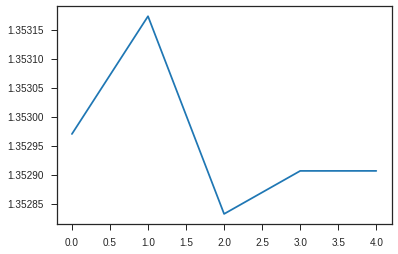

In [12]:
er_bp_o = erisk(X, Y_o, nn_bp_o, loss_func_sq)
fg_bp_o = erm_fg(er_bp_o, h=0.002, tol=1.0e-8, verbose=0, n_restart=5)

plt.plot(fg_bp_o.lvals)
plt.show()

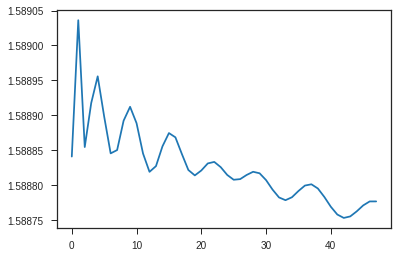

In [13]:
er_sqrt_o = erisk(X, Y_o, nn_sqrt_o, loss_func_sqrt)
fg_sqrt_o = erm_fg(er_sqrt_o, h=0.002, tol=1.0e-8, verbose=0, n_restart=5)

plt.plot(fg_sqrt_o.lvals)
plt.show()

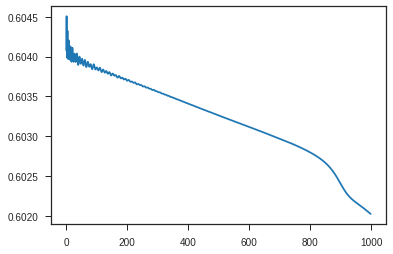

In [14]:
er_logsq_o = erisk(X, Y_o, nn_logsq_o, loss_func_logsq)
fg_logsq_o = erm_fg(er_logsq_o, h=0.002, tol=1.0e-8, verbose=0, n_restart=5)

plt.plot(fg_logsq_o.lvals)
plt.show()

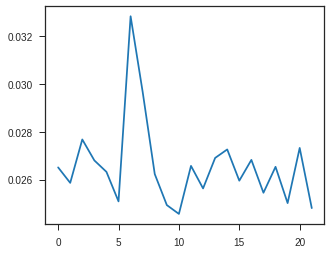

In [20]:
er_wm_o = erisk(X, Y_o, nn_wm_o, loss_func_sq)
fg_wm_o = fg(er_wm_o, h=0.002, tol=1.0e-8)
alpha = 0.99-q
avg_wm_o = averager_it(func.QuantileFunc(alpha, func.Sqrt(0.001)))
wg_wm_o = weights.WMWeights(avg_wm_o, er_wm_o)
irgd_wm_o = erm_irgd(fg_wm_o, wg_wm_o, n_iter=22, verbose=0)

plt.figure(figsize=(5,4))
plt.plot(irgd_wm_o.lvals)
plt.show()

In [16]:
result[Q] = {
    'nn':(
        nn_bp_o, nn_sqrt_o, nn_logsq_o, nn_wm_o),
    'title':(
        'BP | %s%%' % Q,
        'BP $\sqrt{1+x^2}$ | %s%%' % Q,
        'BP $\ln(1+x^2)$ | %s%%' % Q,
        'WM-BP | %s%%' % Q,
    ),
    'b':0.1
}

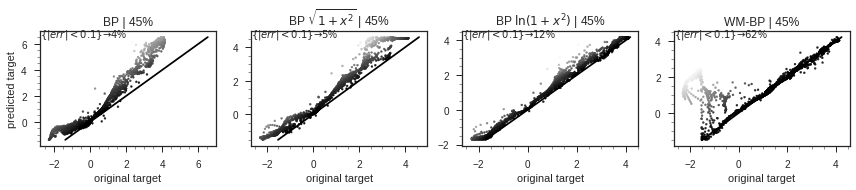

In [17]:
K = 4
m_q = len(result)
plt.figure(figsize=(K*3.0, m_q * 2.75))
for j, Q in enumerate(result):
    for i in range(K):
        current = result[Q]
        b = current['b']
        plt.subplot(m_q, K, K*j+i+1)
        _ffnn = current['nn'][i]
        Y1 = np.array(_ffnn.evaluate_all(X))
        title = current['title'][i]
        plt.title(title)
        V = np.abs(Y-Y1)
        I = np.argsort(V)
        I = I[::-1]
        Y2 = [np.min(Y1), np.max(Y1)]
        plt.plot(Y2, Y2, c='k')
        plt.scatter(Y[I], Y1[I], c=V[I], s=4, cmap=plt.cm.gray)
        c = sum(V < b) / len(V) * 100
        y_min, y_max = plt.xlim()
        plt.text(y_min, Y1.max(), r'$\{|err|<%.1f\}\to%s$%%' % (b, int(c)))
        if i == 0:
            plt.ylabel("predicted target")
        if j == m_q-1:
            plt.xlabel("original target")
        if j < m_q-1:
            plt.xticks([], [])
        plt.minorticks_on()
plt.tight_layout()
plt.savefig(r"fig/isnn2019_regr_%s_%s.eps" % (n_input, n_hidden))
plt.show()

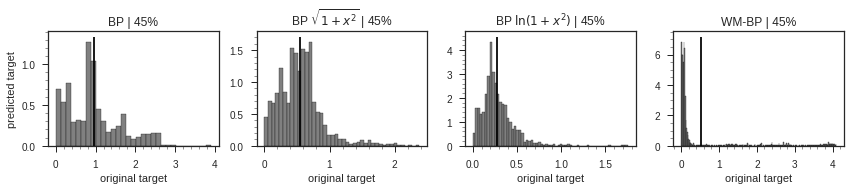

In [18]:
K = 4
m_q = len(result)
plt.figure(figsize=(K*3.0, m_q * 2.75))
for j, Q in enumerate(result):
    for i in range(K):
        current = result[Q]
        b = current['b']
        plt.subplot(m_q, K, K*j+i+1)
        _ffnn = current['nn'][i]
        Y1 = np.array(_ffnn.evaluate_all(X))
        title = current['title'][i]
        plt.title(title)
        V = np.abs(Y-Y1)
        I = np.argsort(V)
        I = I[::-1]
        #Y2 = [np.min(Y1), np.max(Y1)]
        #plt.plot(Y2, Y2, c='k')
        #plt.scatter(Y[I], Y1[I], c=V[I], s=4, cmap=plt.cm.gray)
        plt.hist(V, bins="auto", color='grey', edgecolor='k', density=True)
        _, h_max = plt.ylim()
        plt.vlines(np.mean(V), 0, h_max, colors='k')
        c = sum(V < b) / len(V) * 100
        y_min, y_max = plt.xlim()
        #plt.text(y_min, Y1.max(), r'$\{|err|<%.1f\}\to%s$%%' % (b, int(c)))
        if i == 0:
            plt.ylabel("predicted target")
        if j == m_q-1:
            plt.xlabel("original target")
#         if j < m_q-1:
#             plt.xticks([], [])
        plt.minorticks_on()
plt.tight_layout()
plt.savefig(r"fig/isnn2019_regr_hist_%s_%s.eps" % (n_input, n_hidden))
plt.show()

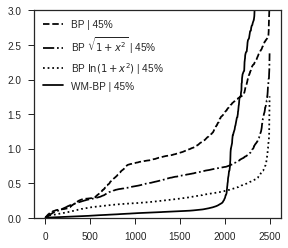

In [19]:
K = 4
m_q = len(result)
lstyles = ['--', '-.', ':', '-']
plt.figure(figsize=(4.0, 3.5))
current = result[Q]
b = current['b']
for i in range(K):
    _ffnn = current['nn'][i]
    Y1 = np.array(_ffnn.evaluate_all(X))
    title = current['title'][i]
    #plt.title(title)
    V = np.abs(Y-Y1)
    Vs = np.sort(V)
    plt.plot(Vs, c='k', linestyle=lstyles[i], label = title)
plt.tight_layout()
plt.ylim(0, 3.0)
plt.legend()
plt.savefig(r"fig/isnn2019_regr_err_%s_%s." % (n_input, n_hidden))
plt.show()